#Downloading Dependencies

In [1]:
!pip install download mindspore
# !pip uninstall mindspore -y
!pip install mindspore-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.0/962.0 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement mindspore-gpu (from versions: none)
ERROR: No matching distribution found for mindspore-gpu


#Downloading The Dataset

In [2]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

download(url, "./datasets-cifar10-bin", kind="tar.gz", replace=True)


Creating data folder...

file_sizes: 100%|████████████████████████████| 170M/170M [00:22<00:00, 7.59MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./datasets-cifar10-bin


'./datasets-cifar10-bin'

#Basic Preprocessing and Creating the CIFAR-10 dataset for training and validation using MindSpore.

In [3]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype
import os

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin"
batch_size = 256
image_size = 32
workers = min(4, os.cpu_count())
num_classes = 10
def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):

    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]
    target_trans = transforms.TypeCast(mstype.int32)
    # Data transformation
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # Batching
    data_set = data_set.batch(batch_size)

    return data_set
# Obtain the preprocessed training and testing datasets
dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()


#Visualizing The Dataset

Image shape: (256, 3, 32, 32), Label shape: (256,)
Labels: [7 1 8 9 8 9]


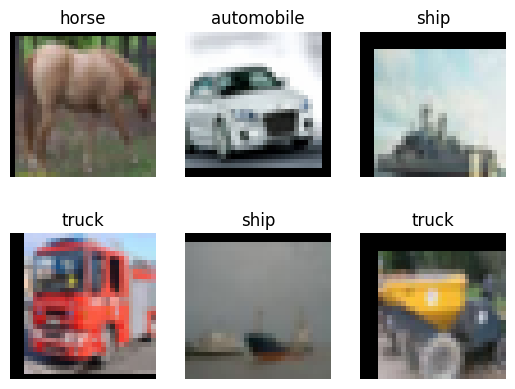

In [4]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# The labels for the first six pictures in the training dataset
print(f"Labels: {labels[:6]}")

classes = []

with open(data_dir + "/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line:
            classes.append(line)

# First six pictures in the training dataset
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()


# Defining a Residual Block for ResNet  
This cell defines the core building block of a ResNet model:  

1. **Imports**  
   - Import necessary types and MindSpore modules.  

2. **Weight Initialization**  
   - Initialize convolutional and batch norm layers using a normal distribution.  

3. **ResidualBlockBase Class**  
   - Defines two convolutional layers with batch normalization and ReLU activation.  
   - Implements a shortcut connection (identity mapping).  
   - Optionally includes downsampling to match dimensions when input and output sizes differ.  

4. **Forward Pass (`construct` method)**  
   - Pass input through two convolutional layers + batch norm + ReLU.  
   - Add shortcut connection (with downsampling if needed).  
   - Apply final ReLU activation to the sum of main and shortcut paths.  


In [5]:
from typing import Type, Union, List, Optional
import mindspore.nn as nn
from mindspore.common.initializer import Normal

weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class ResidualBlockBase(nn.Cell):
    expansion: int = 1

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortcut

        out = self.conv1(x)  # First layer of the main body: 3 x 3 convolutional layer
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # Second layer of the main body: 3 x 3 convolutional layer
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # output the sum of the main body and the shortcuts
        out = self.relu(out)

        return out


#Implementation of Residual Block with Expansion in ResNet

In [6]:
class ResidualBlock(nn.Cell):
    expansion = 4  # The number of convolution kernels at the last layer is four times that of convolution kernels at the first layer.

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortcut

        out = self.conv1(x)  # First layer of the main body: 1 x 1 convolutional layer
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # Second layer of the main body: 3 x 3 convolutional layer
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # Third layer of the main body: 1 x 1 convolutional layer
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # The output is the sum of the main body and the shortcut.
        out = self.relu(out)

        return out


# Creating a Layer of Residual Blocks  
This cell defines a function to create a full layer of residual blocks:  

1. **Function Parameters**  
   - `last_out_channel` – Number of output channels from the previous layer.  
   - `block` – Type of residual block (basic or bottleneck).  
   - `channel` – Number of channels for the current layer.  
   - `block_nums` – Number of residual blocks to stack.  
   - `stride` – Stride for the first block in the layer (default = 1).  

2. **Downsample (Shortcut Connection)**  
   - If the stride is not 1 or the input/output channels don't match, a 1x1 convolution + batch norm is used to match dimensions.  

3. **Create Layer**  
   - First block includes downsampling (if needed).  
   - Remaining blocks are stacked with matching input and output channels.  

4. **Return Layer**  
   - Combine all blocks into a `SequentialCell` for easy layer construction.  


In [7]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)


#This cell defines the complete **ResNet architecture** using residual blocks:  


In [8]:
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # At the first convolutional layer, the number of the input channels is 3 (color image) and that of the output channels is 64.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # Maximum pooling layer, reducing the image size
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # Define each residual network structure block
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # average pooling layer
        self.avg_pool = nn.AvgPool2d()
        # flattern layer
        self.flatten = nn.Flatten()
        # fully-connected layer
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


# Loading and Initializing ResNet Model  
This cell defines functions to create and load a ResNet model (e.g., ResNet-50):  

1. **_resnet Function**  
   - Creates a ResNet model using the `ResNet` class.  
   - If `pretrained=True`, it:  
     - Downloads the pre-trained model.  
     - Loads the checkpoint into the model using `load_checkpoint` and `load_param_into_net`.  
   - Returns the initialized model.  

2. **resnet50 Function**  
   - Creates a ResNet-50 model using `_resnet`.  
   - Downloads and loads pre-trained weights from a specified URL (if `pretrained=True`).  
   - Configures the ResNet-50 architecture with `[3, 4, 6, 3]` residual blocks.  
   - Sets the number of output classes (`num_classes`).  

3. **Purpose**  
   - Allows easy initialization of a ResNet-50 model (with or without pre-trained weights).  
   - Ensures that model architecture and weights are consistent.  


In [9]:
def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrained_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # load pre-trained models
        download(url=model_url, path=pretrained_ckpt, replace=True)
        param_dict = load_checkpoint(pretrained_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    """ResNet50 model"""
    resnet50_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)


# Defining the ResNet50 network.

In [10]:
network = resnet50(pretrained=True)

# Size of the input layer of the fully-connected layer
in_channel = network.fc.in_channels
fc = nn.Dense(in_channels=in_channel, out_channels=10)
# Reset the fully-connected layer.
network.fc = fc



file_sizes: 100%|████████████████████████████| 102M/102M [00:14<00:00, 7.29MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt


## Defining the Training Setup

This cell sets up the learning rate, optimizer, and training step for the ResNet model:

1. **Learning Rate Schedule**

2. **Optimizer**

3. **Loss Function**

4. **Forward Function**


Training with SGD...

file_sizes: 100%|████████████████████████████| 102M/102M [00:14<00:00, 6.84MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt
Epoch: [1/1], Step: [1/196], Loss: 2.3143
Epoch: [1/1], Step: [101/196], Loss: 2.3690
Epoch: [1/1], Step: [196/196], Loss: 2.3274


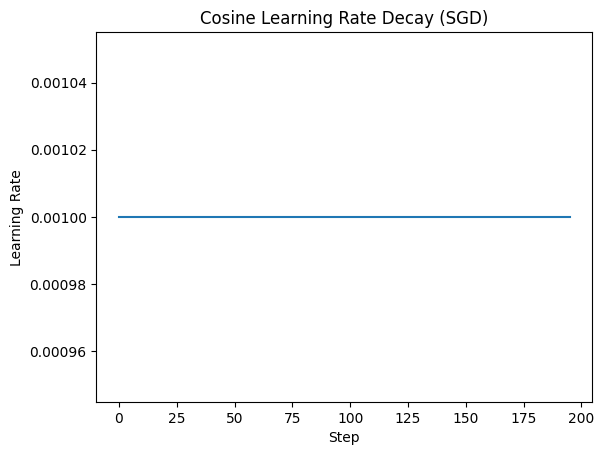

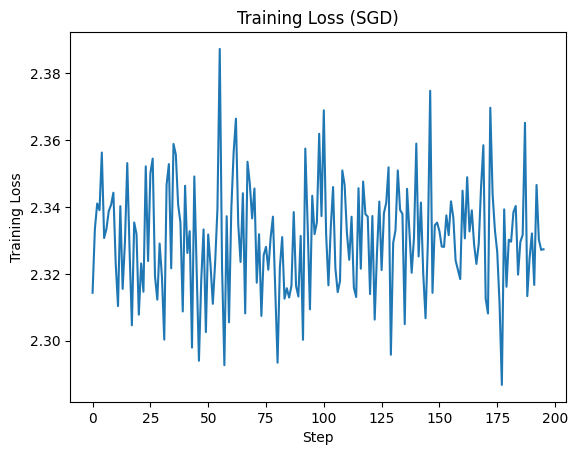

Training with Adam...

file_sizes: 100%|████████████████████████████| 102M/102M [00:12<00:00, 8.16MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt
Epoch: [1/1], Step: [1/196], Loss: 2.3049
Epoch: [1/1], Step: [101/196], Loss: 2.3258
Epoch: [1/1], Step: [196/196], Loss: 2.3251


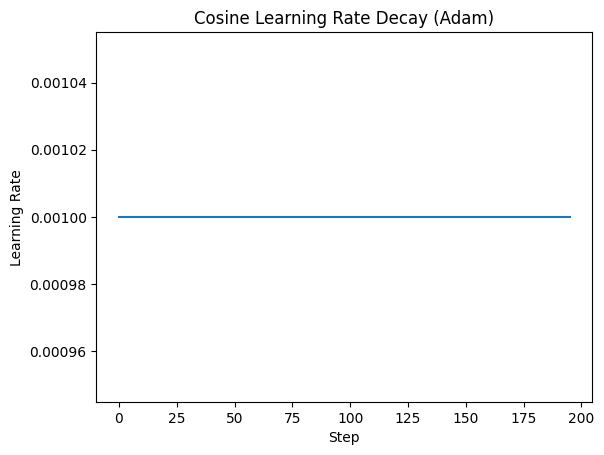

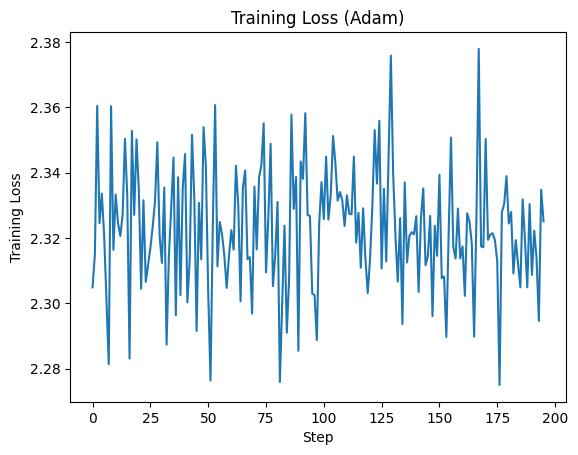

Training with Momentum...

file_sizes: 100%|████████████████████████████| 102M/102M [00:11<00:00, 9.21MB/s]
Successfully downloaded file to ./LoadPretrainedModel/resnet50_224_new.ckpt
Epoch: [1/1], Step: [1/196], Loss: 2.3091
Epoch: [1/1], Step: [101/196], Loss: 2.3377
Epoch: [1/1], Step: [196/196], Loss: 2.3120


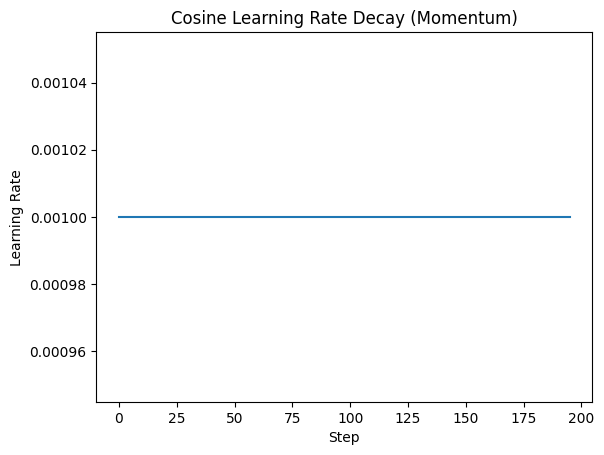

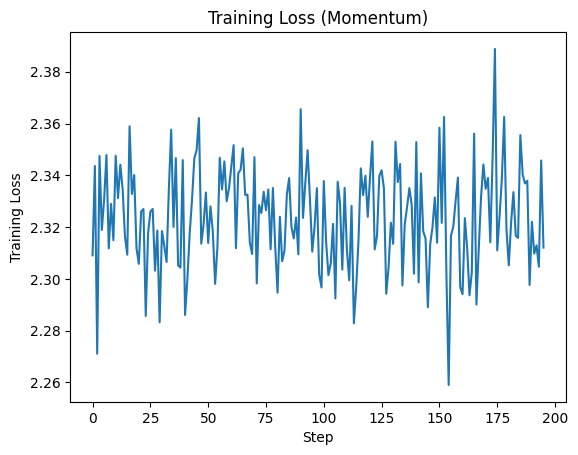

In [11]:
import mindspore.nn as nn
import mindspore as ms
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 1

# Define learning rate schedule (same for all optimizers for comparison)
lr = nn.cosine_decay_lr(
    min_lr=0.00001,
    max_lr=0.001,
    total_step=step_size_train * num_epochs,
    step_per_epoch=step_size_train,
    decay_epoch=num_epochs
)

# Store learning rates for visualization
learning_rates = []
for i in range(step_size_train * num_epochs):
  learning_rate_value = lr[i]  # Get the learning rate value
  if isinstance(learning_rate_value, ms.Tensor):  # Check if it's a MindSpore Tensor
    learning_rates.append(learning_rate_value.asnumpy())  # Convert to NumPy if it is
  else:
    learning_rates.append(learning_rate_value)  # Append directly if it's a float

# Define optimizers
optimizers = {
    'SGD': nn.SGD(network.trainable_params(), learning_rate=lr),
    'Adam': nn.Adam(network.trainable_params(), learning_rate=lr),
    'Momentum': nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
}

# Define loss function
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# Training loop (adapt from your existing code)
for optimizer_name, optimizer in optimizers.items():
    print(f"Training with {optimizer_name}...")
    # Reset the network weights for each optimizer
    network = resnet50(pretrained=True)
    in_channel = network.fc.in_channels
    fc = nn.Dense(in_channels=in_channel, out_channels=10)
    network.fc = fc

    def forward_fn(inputs, targets):
        logits = network(inputs)
        loss = loss_fn(logits, targets)
        return loss

    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

    def train_step(inputs, targets):
        loss, grads = grad_fn(inputs, targets)
        optimizer(grads)
        return loss

    # Collect training losses for plotting
    train_losses = []

    for epoch in range(num_epochs):
        # Reset data loader for each epoch
        data_loader_train = dataset_train.create_tuple_iterator(num_epochs=1)
        for i, (images, labels) in enumerate(data_loader_train):
            loss = train_step(images, labels)
            train_losses.append(loss.asnumpy())  # Store as numpy value

            if i % 100 == 0 or i == step_size_train - 1:
                print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{i+1}/{step_size_train}], Loss: {loss.asnumpy():.4f}')
    # Plot learning rate schedule for the current optimizer
    plt.figure()
    plt.plot(learning_rates)
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.title(f"Cosine Learning Rate Decay ({optimizer_name})")
    plt.show()

    # Plot training loss for the current optimizer
    plt.figure()
    plt.plot(train_losses)
    plt.xlabel("Step")
    plt.ylabel("Training Loss")
    plt.title(f"Training Loss ({optimizer_name})")
    plt.show()